# Перетворення Фур'є

У даній лабораторній роботі розглянуто наступні приклади перетворень Фур'є:
1. Перетворення Фур'є у Numpy
        1.1. Фільтр високих частот 
2. Перетворення Фур'є в OpenCV
        2.1. Фільтр низьких частот
3. Зниження роздільної здатності за допомогою Гауссового фільтра
4. Підвищення роздільної здатності зображення за допомогою ДПФ
5. Відновлення розмитого зображення за допомогою ДПФ

### Імпортуємо необхдіні пакети та бібліотеки

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy.ndimage import gaussian_filter
import scipy.fftpack as fp
from scipy import signal

<h3>Pad with zeros function define</h3>

In [26]:
def padwithzeros(vector, pad_width, iaxis, kwargs):
    vector[:pad_width[0]] = 0
    vector[-pad_width[1]:] = 0
    return vector

### 1. Перетворення Фур'є у Numpy

Numpy має пакет FFT для знаходження швидкого перетворення Фур'є. **np.fft.fft2()** забезпечує перетворення частоти, яке буде складним масивом. Перший її аргумент - це вхідне зображення, у відтінках сірого. Другий аргумент необов'язковий, який визначає розмір вихідного масиву. Якщо він перевищує розмір вхідного зображення, вхідне зображення заповнюється нулями перед обчисленням FFT. Якщо воно менше, ніж вхідне зображення, вхідне зображення буде обрізане. Якщо жодних аргументів не передано, розмір вихідного масиву буде таким самим, як і вхідний.

Після отримання результату, компонент нульової частоти  буде у верхньому лівому куті. Якщо його необхідно довести до центру, потрібно перенести результат на N/2 в обох напрямках. Це робиться функцією, **np.fft.fftshift()**.

### Зчитаємо вихідне зображення:

In [2]:
img = cv2.imread("./examples/Fig0429a.tif",0)

## Швидке перетворення Фур'є (ШПФ)

### Синтаксис функції
    numpy.fft.fft2(a, s=None, axes=(-2, -1), norm=None)
Параметри:
* **a** - вхідне зображення (масив);
* **s** - розмір вхідного масиву;
* **norm** -  режим нормалізації.

### Синтаксис функції
    numpy.fft.fftshift(x, axes=None)
Параметри:
* **x** - вхідне зображення (масив);
* **axes** - ось зсуву.

In [43]:
f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20*np.log(np.abs(fshift))

### Вихідне зображення та його спектр

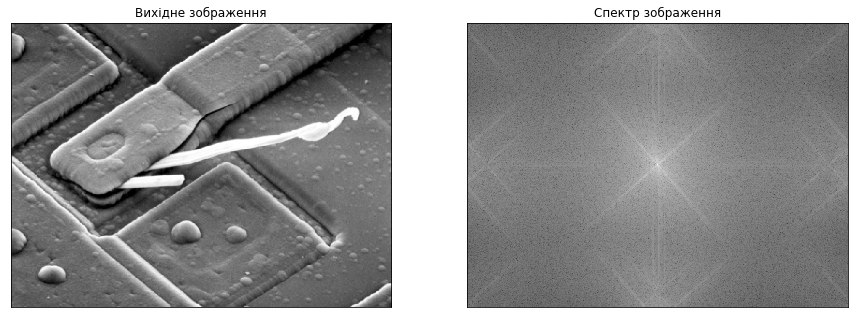

In [48]:
plt.figure(figsize=(15,15))
plt.subplot(121),plt.imshow(img, cmap = 'gray')
plt.title('Вихідне зображення'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Спектр зображення'), plt.xticks([]), plt.yticks([])
plt.show()

Можна побачити більше білого регіону в центрі, де низьих частот більше.

Отже, знайдене частотне перетворення. Тепер можна можна робити деякі операції в частотній області, наприклад, фільтрування високої частоти та реконструкцію зображення, тобто пошук зворотного ШПФ.

### 1.1. Фільтр високих частот в частотній області

Для реалізаціії фільтру виских частот видаляють низькі частоти, маскуючи прямокутне вікно розміром 60x60. Потім застосовують зворотний зсув, використовуючи **np.fft.ifftshift()**, щоб постійна складова (нульова частота) знову потрапила у верхній лівий кут. Потім знаходяьть обернене ШПФ за допомогою функції **np.ifft2()**.

In [45]:
rows, cols = img.shape
crow,ccol = rows/2 , cols/2
fshift[int(crow-30):int(crow+30), int(ccol-30):int(ccol+30)] = 0
f_ishift = np.fft.ifftshift(fshift)
img_back = np.fft.ifft2(f_ishift)
img_back = np.abs(img_back)

### Вихідне зображення та зображення після фільтру високої частоти

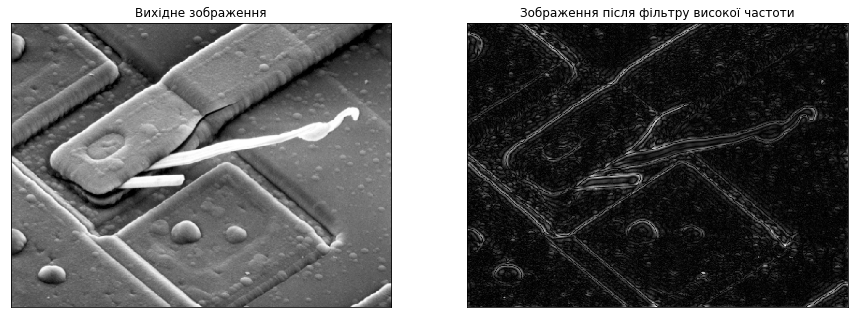

In [47]:
plt.figure(figsize=(15,15))
plt.subplot(121),plt.imshow(img, cmap = 'gray')
plt.title('Вихідне зображення'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img_back, cmap = 'gray')
plt.title('Зображення після фільтру високої частоти'), plt.xticks([]), plt.yticks([])
plt.show()

### Перетворення Фур'є в OpenCV

OpenCV надає для цього функції **cv2.dft()** і **cv2.idft()**. Вона повертає той самий результат, що і попередній метод, але з двома каналами. Перший канал матиме реальну частину результату, а другий канал матиме уявну частину результату. Вхідне зображення спочатку слід перетворити на np.float32.

### Синтаксис функції
    cv2.dft(src, dst, flags, nonzeroRows=0)
Параметри:
* **src** - вхідне зображення у форматі float32;
* **s** - вихідний масив, розмір і тип якого залежить від **flags**;
* **flags** -  прапори трансформації, що представляють собою комбінацію наступних значень:
    * **DFT_INVERSE** виконує зворотне 1D або 2D перетворення замість перетворення за замовчуванням.
    * DFT_SCALE масштабує результат: ділить його на кількість елементів масиву. Зазвичай він поєднується з DFT_INVERSE.
    * **DFT_ROWS** виконує пряме або зворотне перетворення кожного окремого рядка вхідної матриці.
    * **DFT_COMPLEX_OUTPUT** виконує пряму трансформацію 1D або 2D реального масиву.
    * **DFT_REAL_OUTPUT** виконує зворотне перетворення 1D або 2D складного масиву.
* **nonzeroRows** - коли параметр не дорівнює нулю, функція передбачає, що лише перші рядки nonroroRows вхідного масиву або лише перші ненульові ряди вихідного масиву містять не нулі, таким чином, функція може ефективніше обробляти решту рядків і економити час.

In [49]:
dft = cv2.dft(np.float32(img),flags = cv2.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)
magnitude_spectrum = 20*np.log(cv2.magnitude(dft_shift[:,:,0],dft_shift[:,:,1]))

### Вихідне зображення та його спектр

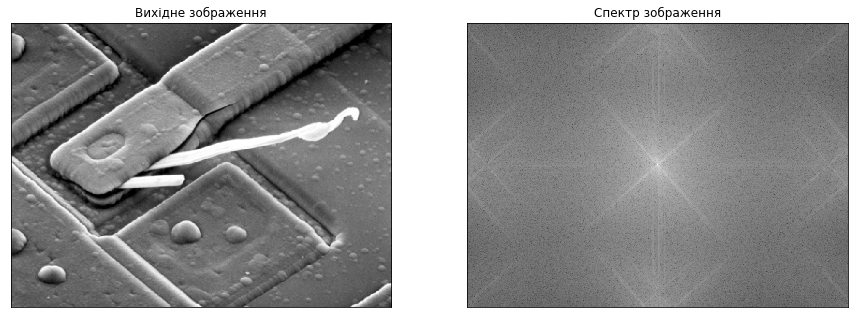

In [50]:
plt.figure(figsize=(15,15))
plt.subplot(121),plt.imshow(img, cmap = 'gray')
plt.title('Вихідне зображення'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Спектр зображення'), plt.xticks([]), plt.yticks([])
plt.show()

Отже, тепер потрібно зробити зворотнє ШПФ. Вище було створено фільтр високих частот (HPF), на цей раз ми побачимо, як видалити вміст з високою частотою на зображенні, тобто застосуємо фільтр низьких частот (LPF) до зображення. Він розмиває зображення. Для цього створюється маска спочатку з високим значенням (1) на низьких частотах, тобто передається вміст низьких частот і 0 в область високих частот.

In [51]:
rows, cols = img.shape
crow,ccol = rows/2 , cols/2

### Створюємо маску з 1 в центрі

In [53]:
mask = np.zeros((rows,cols,2),np.uint8)
mask[int(crow-30):int(crow+30), int(ccol-30):int(ccol+30)] = 1


### Застосування зворотнього ШПФ

In [54]:
fshift = dft_shift*mask
f_ishift = np.fft.ifftshift(fshift)
img_back = cv2.idft(f_ishift)
img_back = cv2.magnitude(img_back[:,:,0],img_back[:,:,1])

### Вихідне зображення та заображення після фільтру низької частоти

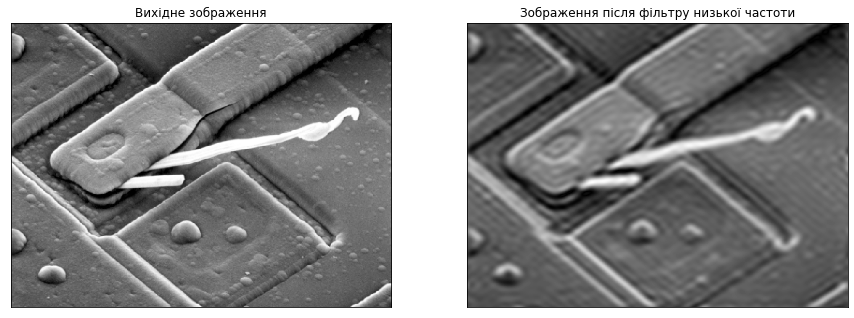

In [55]:
plt.figure(figsize=(15,15))
plt.subplot(121),plt.imshow(img, cmap = 'gray')
plt.title('Вихідне зображення'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img_back, cmap = 'gray')
plt.title('Зображення після фільтру низької частоти'), plt.xticks([]), plt.yticks([])
plt.show()

### Зниження роздільної здатності за допомогою Гауссового фільтра

1. Зменшимо розмір зображення в 16 разів, зменшивши висоту і ширину в 4 рази.
2. Оберемо кожен 4-й піксель у напрямку x та y вихідного зображення, щоб обчислити значення пікселів на меншому зображенні.
3. Перед початком відбору проб застосуємо фільтр Гаусса (щоб згладити зображення).
4. Порівняємо якість вихідного зображення, отриманого шляхом вибірки вниз, без фільтра Гаусса.

(678, 906)


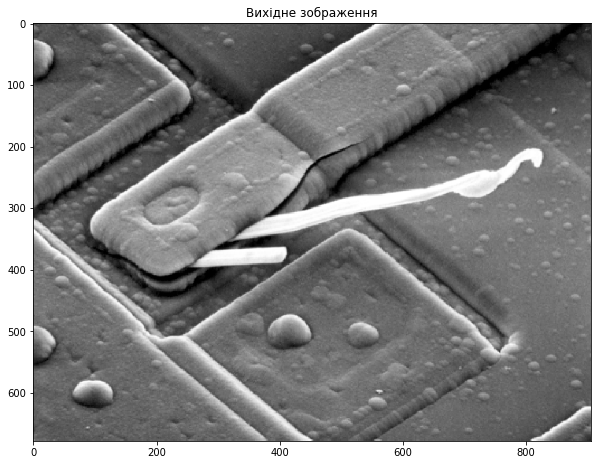

In [57]:
print(img.shape)
plt.figure(figsize=(10,10))
plt.imshow(img, cmap = 'gray'); plt.title('Вихідне зображення')
plt.show()

### Синтаксис функції
    scipy.ndimage.gaussian_filter(input, sigma, order=0, output=None, mode='reflect', cval=0.0, truncate=4.0)
Параметри:
* **input** - вхідне зображення (масив);
* **sigma** - Стандартне відхилення для ядра Гаусса. Стандартні відхилення фільтра Гаусса задаються для кожної осі як послідовність, або як єдине число, у цьому випадку вона дорівнює для всіх осей.

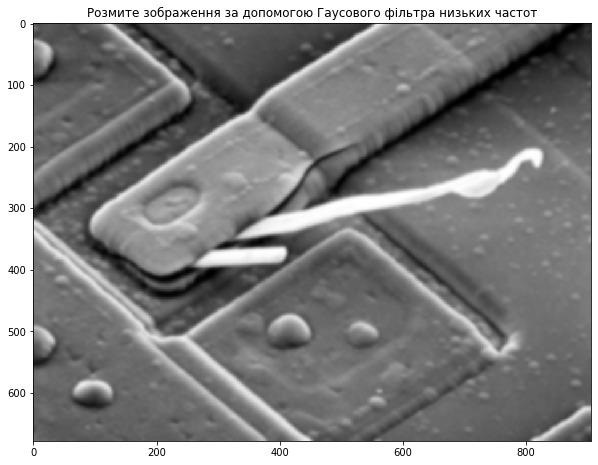

In [58]:
plt.figure(figsize=(10,10))
im_blurred = gaussian_filter(im, sigma=2.5)
plt.imshow(im_blurred, cmap = 'gray'); plt.title('Розмите зображення за допомогою Гаусового фільтра низьких частот')
plt.show()

### Створення нового зображення в 16 разів менше за вихідне

In [59]:
n = 4 
w, h = im.shape[0] // n, im.shape[1] // n
im_small = np.zeros((w,h))
for i in range(w):
   for j in range(h):
      im_small[i,j] = im[n*i, n*j]

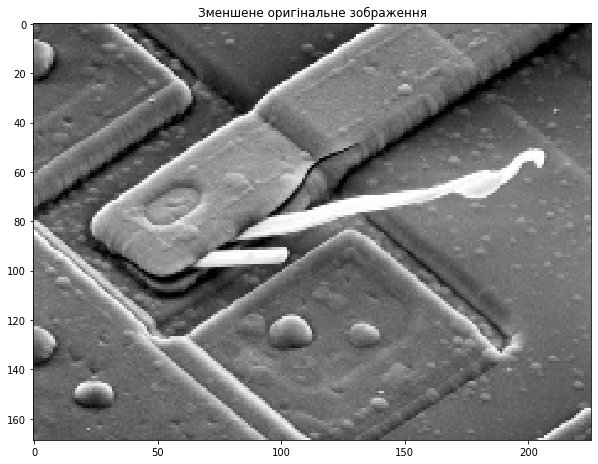

In [60]:
plt.figure(figsize=(10,10))
plt.imshow(im_small, cmap = 'gray'); plt.title('Зменшене оригінальне зображення')
plt.show()

### Створення нового зображення в 16 разів менше за розмите зображення

In [17]:
im_small = np.zeros((w,h))
for i in range(w):
   for j in range(h):
      im_small[i,j] = im_blurred[n*i, n*j]

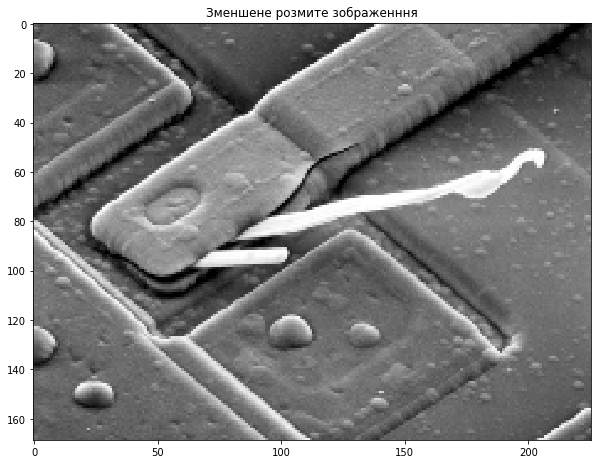

In [61]:
plt.figure(figsize=(10,10))
plt.imshow(im_small, cmap = 'gray'); plt.title('Зменшене розмите зображенння')
plt.show()

<h2>Frequency Domain Gaussian Filter</h2>

1. Use an input image and use DFT to create the frequency 2D-array.
2. Create a small Gaussian 2D Kernel (to be used as an LPF) in the spatial domain and pad it to enlarge it to the image dimensions.
3. Use DFT to obtain the Gaussian Kernel in the frequency domain.
4. Use the Convolution theorem to convolve the LPF with the input image in the frequency domain.
5. Use IDFT to obtain the output image.
6. Plot the frequency spectrum of the image, the gaussian kernel and the image obtained after convolution in the frequency domain, in 3D.

In [19]:
kernel = np.outer(signal.gaussian(im.shape[0], 5), signal.gaussian(im.shape[1], 5))
freq = fp.fft2(im)
assert(freq.shape == kernel.shape)
freq_kernel = fp.fft2(fp.ifftshift(kernel))
convolved = freq*freq_kernel # by the Convolution theorem
im_blur = fp.ifft2(convolved).real
im_blur = 255 * im_blur / np.max(im_blur)

<h3>Plot original Image and Blurred Image</h3>

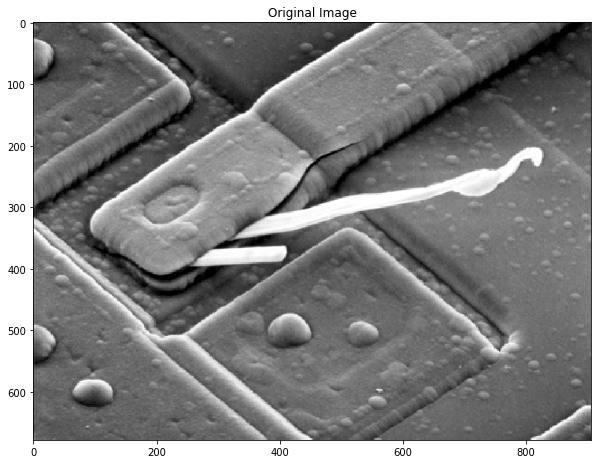

In [20]:
plt.figure(figsize=(10,10))
plt.imshow(im, cmap = 'gray'); plt.title('Original Image')
plt.show()

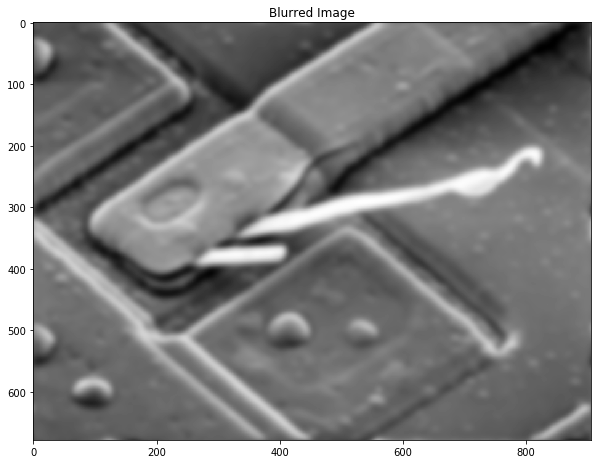

In [21]:
plt.figure(figsize=(10,10))
plt.imshow(im_blur, cmap='gray'); plt.title('Blurred Image')
plt.show()

<h2>Using DFT to up-sample an image</h2>

1. Let’s use gray-scale image.
2. First double the size of the by padding zero rows/columns at every alternate positions.
3. Use FFT followed by an LPF.
4. Finally use IFFT to get the output image.

In [22]:
im = img
im1 = np.zeros((2*im.shape[0], 2*im.shape[1]))
print(im.shape, im1.shape)

(678, 906) (1356, 1812)


In [23]:
for i in range(im.shape[0]):
    for j in range(im.shape[1]):
        im1[2*i,2*j] = im[i,j]

<h3>The LPF kernel</h3>

In [24]:
kernel = [[0.25, 0.5, 0.25], [0.5, 1, 0.5], [0.25, 0.5, 0.25]]

<h3>Enlarge the kernel to the shape of the image</h3>

In [27]:
kernel = np.pad(kernel, (((im1.shape[0]-3)//2,(im1.shape[0]-3)//2+1), ((im1.shape[1]-3)//2,(im1.shape[1]-3)//2+1)), padwithzeros)

In [28]:
freq = fp.fft2(im1)
freq_kernel = fp.fft2(fp.ifftshift(kernel))
freq_LPF = freq*freq_kernel # by the Convolution theorem
im2 = fp.ifft2(freq_LPF)
freq_im2 = fp.fft2(im2)

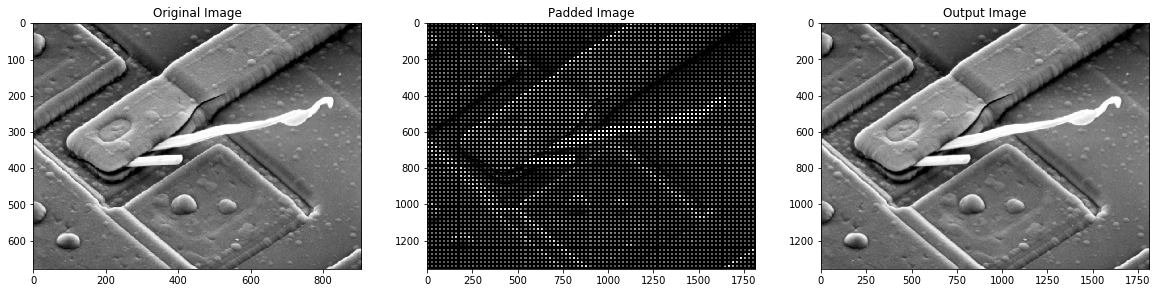

In [29]:
plt.figure(figsize=(20,15))
plt.gray()
plt.subplot(1,3,1)
plt.imshow(im)
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(im1)
plt.title('Padded Image')
plt.subplot(1,3,3)
plt.imshow(im2.real) # the imaginary part is an artifact
plt.title('Output Image')
plt.show()

<h2>Using the inverse filter to restore a motion-blurred image</h2>

1. First create a motion blur kernel of a given shape.
2. Convolve the kernel with an input image in the frequency domain.
3. Get the motion-blurred image in the spatial domain with IDFT.
4. Compute the inverse filter kernel and convolve with the blurred image in the frequency domain.
4. Get the convolved image back in the spatial domain.
5. Plot all the images and kernels in the frequency domain.

<h3>Create the motion blur kernel</h3>

In [37]:
size = 21
kernel = np.zeros((size, size))
kernel[int((size-1)/2), :] = np.ones(size)
kernel = kernel / size
kernel = np.pad(kernel, (((img.shape[0]-size)//2,(img.shape[0]-size)//2+1), ((img.shape[1]-size)//2,(img.shape[1]-size)//2+1)), padwithzeros)

In [38]:
freq = fp.fft2(img)
freq_kernel = fp.fft2(fp.ifftshift(kernel))
convolved1 = freq*freq_kernel
im_blur = fp.ifft2(convolved1).real
im_blur = im_blur / np.max(im_blur)

In [39]:
epsilon = 10**-6

In [40]:
freq = fp.fft2(im_blur)
freq_kernel = 1 / (epsilon + freq_kernel)

In [41]:
convolved = freq*freq_kernel
im_restored = fp.ifft2(convolved).real
im_restored = im_restored / np.max(im_restored)

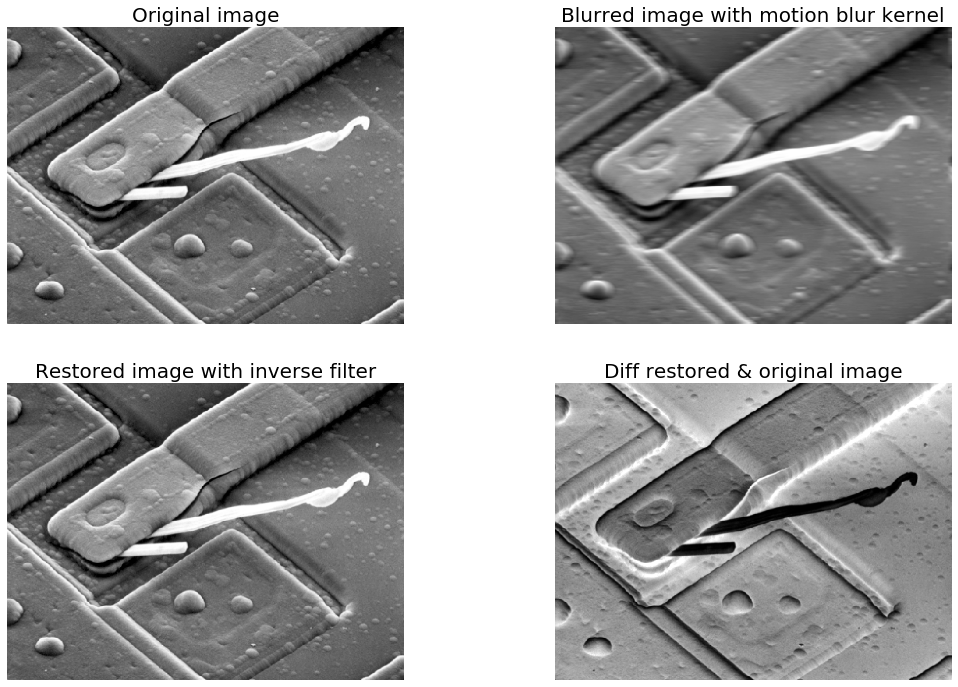

In [42]:
plt.figure(figsize=(18,12))
plt.subplot(221)
plt.imshow(img)
plt.title('Original image', size=20)
plt.axis('off')
plt.subplot(222)
plt.imshow(im_blur)
plt.title('Blurred image with motion blur kernel', size=20)
plt.axis('off')
plt.subplot(223)
plt.imshow(im_restored)
plt.title('Restored image with inverse filter', size=20)
plt.axis('off')
plt.subplot(224)
plt.imshow(im_restored - im)
plt.title('Diff restored & original image', size=20)
plt.axis('off')
plt.show()